In [1]:
# Import required dependencies
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

%matplotlib inline

# Utility function to print a box
def print_msg_box(msg, indent=1, width=None, title=None):
    """Print message-box with optional title."""
    lines = msg.split('\n')
    space = " " * indent
    if not width:
        width = max(map(len, lines))
    box = f'╔{"═" * (width + indent * 2)}╗\n'  # upper_border
    if title:
        box += f'║{space}{title:<{width}}{space}║\n'  # title
        box += f'║{space}{"-" * len(title):<{width}}{space}║\n'  # underscore
    box += ''.join([f'║{space}{line:<{width}}{space}║\n' for line in lines])
    box += f'╚{"═" * (width + indent * 2)}╝'  # lower_border
    print(box, flush=True)

## Data summary 

In [2]:
#Load the cleaned, processed and aggregated data
processed_data = pd.read_csv('processed_data.csv')

              precision    recall  f1-score   support

           A       0.49      0.44      0.47       189
           D       0.29      0.06      0.10       168
           H       0.54      0.81      0.65       310

    accuracy                           0.52       667
   macro avg       0.44      0.44      0.40       667
weighted avg       0.46      0.52      0.46       667



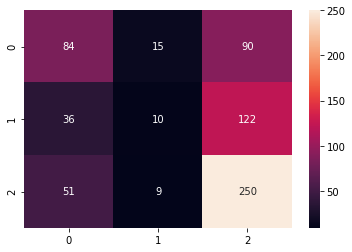

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Separate the data into features and prediction target
# Full Time Result (H=Home Team Win, D=Draw, A=Away Team Win)
df = processed_data.copy().drop(columns=['Date', 'HomeTeam', 'AwayTeam', 'HS', 'AS', 'HST', 'AST', 'FTHG', 'FTAG', 'HC', 'AC'])
data = df[~df[df.columns[1:]].isin((0, 0.0)).all(axis=1)]
X_all = data.drop(['FTR'],1)
y_all = data['FTR']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = 0.1,
                                                    random_state = 3,
                                                    stratify = y_all)


# Random Forrest algorithm to fit the training data
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
classifier.fit(X_train, y_train)

# Prediction result of test data
Y_pred = classifier.predict(X_test)

# Generating and printing the confusion matrix
confMat = confusion_matrix(y_test, Y_pred)
sns.heatmap(confMat, annot=True,fmt='d')
print(classification_report(y_test, Y_pred))


## Prediction System 

> Predictions are based on a professional league season. 
> Input data are cumulative values until the matchweek that is being predicted.

In [4]:
from IPython.display import display, Markdown, clear_output
from ipywidgets import VBox, HBox, Label, Layout, Output, Button, BoundedIntText


# Map of Full Time Result (FTR) value and appropriate description
ftr_map = {'H': 'Home team wins!!', 'A': 'Away team wins!!', 'D': 'Draw'}

# Create a text input box and label widget
def create_input(label):
    label_layout = Layout(width='auto',height='30px')
    return HBox([Label(label,layout=label_layout), BoundedIntText(
                min=0,
                max=100000,
                step=1,
                description='',
                disabled=False)])

# Create the input widget for each parameter required for prediction
htsm = create_input('Home team total shots made (HTSM): ')
atsm = create_input('Away team total shots made (ATSM): ')
htsc = create_input('Home team total shots conceded (HTSC): ')
atsc = create_input('Away team total shots conceded (ATSC): ')
htags = create_input('Home team aggregate goal scored (HTAGS): ')
atags = create_input('Away team aggregate goal scored (ATAGS): ')
htagc = create_input('Home team aggregate goal conceded (HTAGC): ')
atagc = create_input('Away team aggregate goal conceded (ATAGC): ')
htap = create_input('Home team total points (HTAP): ')
atap = create_input('Away team total points (ATAP): ')
htws = create_input('Home team win streak (HTWS): ')
atws = create_input('Away team win streak (ATWS): ')

# Extract input value from a HBox
def getInputValue(hbox):
    return hbox.children[1].value

# Create Predict button which runs predictions on click
predict_button = Button(description='Predict', button_style='primary')

input_boxes = VBox([htsm, atsm, htsc, atsc, htags, atags, htagc, atagc, htap, atap, htws, atws])
full_input_form = VBox([input_boxes, predict_button])
display(full_input_form)

out = Output()
display(out)

# Callback function which runs after hitting Predict button
# This function runs the prediction and prints the result
def run_prediction(b):
    with out:
        inp = pd.DataFrame(
        [[getInputValue(htsm), getInputValue(atsm), getInputValue(htsc), getInputValue(atsc), getInputValue(htags), getInputValue(atags), getInputValue(htagc), getInputValue(atagc), getInputValue(htap), getInputValue(atap), getInputValue(htws), getInputValue(atws)]], 
        columns=['HTSM', 'ATSM', 'HTSC', 'ATSC','HTAGS','ATAGS','HTAGC','ATAGC','HTAP','ATAP','HTWS','ATWS'])
        result = classifier.predict(inp)[0]

        clear_output()
        # Printing the prediction result
        print_msg_box('Prediction based on following data:\n'+ str(inp) + '\nPrediction result:\n' + str(ftr_map.get(result)))

predict_button.on_click(run_prediction)

Output()